# Project Agenda

Venn diagram of clinician-consensus diagnoses shows that:
- **Neurodevelopmental and anxiety disorders overlap substantially**, and
- Within neurodevelopmental diagnoses, **ADHD, ASD, and SLD show diverse and overlapping
  patterns** rather than cleanly separated groups.

These patterns suggest that categorical diagnoses may have multiple cognitive–motivational “types”
within and across diagnostic labels.

I use machine learning–derived clusters to ask:

1. **Do these clusters faithfully summarize EF/TD patterns?**  
   - Are they internally valid (stable across runs, clearly separated in EF/TD space)?

2. **Do these clusters faithfully connect to clinical outcomes?**  
   - **Categorical diagnoses:** neurodevelopmental disorders, SLD, ASD, ADHD, anxiety  
     - Via chi-square tests, Cramér’s V, age/sex-adjusted odds ratios, and AUC.  
   - **Dimensional symptom/impairment measures (current and future work):**  
     - Symptom scales and functioning scores as transdiagnostic readouts.

---

## Motivation

### (a) Descriptive Uitility

Clinicians and families do not usually think in 5D z-score space. They ask questions like:

- “Is this child more of an *EF-impaired but overactive* type, or an *EF-impaired but shut down* type?”  
- “Are there distinct patterns that call for different kinds of support?”

Clusters provide **named profiles** instead of a vector of scores, for example:

- “impulsive & inconsistent”  
- “impulsive but consistent”  
- “patient despite low EF”  
- “high performers”

These profiles do not intend to outperform raw EF/TD scores in diagnostic **prediction**, they are for the purpose of better diagnostic **description**:

- more **clinically intuitive**,  
- easier to **remember and discuss**, and  
- easier to **embed in practice** than multiple separate EF/TD indices.

A simple 4-cluster profile can, in principle, be used as a quick way to think about cognitive–motivational patterns when planning supports.

### (b) Interpretive Utility: subtyping and heterogeneity

A core question is:

- “Within ADHA/SLD/ASD/anxiety, are there **different cognitive–motivational types**?”

Raw scores give continuous dimensions; they do *not* directly give “types.” Clusters can:

- identify **subgroups within the same diagnosis**,  
- define **profiles that cut across diagnoses** (transdiagnostic phenotypes), and  
- help characterize heterogeneity, e.g., ND children who are impulsive vs ND children who are patient but EF-impaired.

In this view, clusters are not meant to replace diagnoses, but to **organize heterogeneity** in EF/TD profiles within and across diagnostic categories.

---

## Approach

- **Internal validity of clusters (03 notebook):**  
  - Evaluate stability (across seeds/subsamples) and separation in EF/TD space.

- **External validity vs diagnoses (06 notebook):**  
  - Test cluster–diagnosis associations using chi-square and bias-corrected Cramér’s V.  
  - Compute age/sex-adjusted odds ratios.  
  - Compare supervised models (logistic regression) using:  
    - EF/TD scores only vs  
    - EF/TD scores + cluster membership, via cross-validated AUC.

- **Planned/ongoing:**  
  - Extend external validity to **dimensional symptom and functioning measures**, using cluster profiles on key scales (e.g., internalizing/externalizing, ASD traits, global functioning).

---

## Conclusion

In this project, I distinguish between three kinds of utility:

1. **Diagnostic utility**  
> *Can clusters serve as a better diagnostic tool than raw EF/TD scores?*  

I assessed this by comparing supervised models predicting diagnoses from:
   - EF/TD scores alone vs
   - EF/TD scores plus cluster membership (cross-validated AUC).

Adding cluster membership did **not** meaningfully improve AUC, indicating **limited diagnostic utility** beyond the original EF/TD measures.

2. **Descriptive utility (for communication)**  
> *Do clusters provide a clearer way to describe EF/TD patterns?*  

Instead of a 5-dimensional profile of z-scores and discounting parameters, clusters yield a small set of intuitive profiles:
   - “impulsive & inconsistent”
   - “impulsive but consistent”
   - “patient despite low EF”
   - “high performers”

3. **Interpretative utility (for heterogeneity and subtyping)**  
> *Do clusters help interpret heterogeneity within and across diagnoses?*  

Clusters provide **cognitive–motivational subtypes** that:
   - reveal how neurodevelopmental, SLD, and ASD diagnoses are distributed across different EF/TD profiles, and  
   - can be linked to dimensional symptom and functioning measures in future work.

**Hence:**  
Clusters in this project are **not primarily diagnostic tools**. Their value lies in their **descriptive utility** (providing intuitive profiles for communication) and **interpretative utility** (organizing heterogeneity and subtyping within and across diagnostic categories).

# Setup

In [46]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

plt.rcParams['figure.dpi'] = 160
sns.set_style("whitegrid")
sns.set_context("notebook")

In [4]:
def find_project_root(start: Path | None = None) -> Path:
    """Return the repo root by searching upward for markers."""
    p = (start or Path.cwd()).resolve()
    markers = {".git", "environment.yml", "README.md"}
    while True:
        if any((p / m).exists() for m in markers):
            return p
        if p.parent == p:
            # fallback: use start if nothing found
            return (start or Path.cwd()).resolve()
        p = p.parent

# Allow manual override via env var if needed
ROOT = Path(os.environ.get("HBN_PROJ_ROOT", find_project_root()))

# --- Paths for INPUT data ---
CORE_PATH   = ROOT / "data" / "processed" / "hbn_core_view_v1.csv"
CLUSTER_PATH = ROOT / "results" / "kmeans_model" / "cluster_assignments.csv"
FLAGS_PATH  = ROOT / "data" / "processed" / "hbn_diag_flags_neuro_anx.csv"

# --- Paths for OUTPUT (this notebook) ---
RESULTS_DIR = ROOT / "results" / "kmeans_diagnosis"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

MERGED_PROCESSED_PATH = ROOT / "data" / "processed" / "hbn_core_clusters_diag.csv"
MERGED_INTERIM_PATH   = ROOT / "data" / "interim"   / "hbn_core_clusters_diag.csv"

print("Project root: ", ROOT)
print("Core data   : ", CORE_PATH)
print("Clusters    : ", CLUSTER_PATH)
print("Diag flags  : ", FLAGS_PATH)
print("Results dir : ", RESULTS_DIR)

Project root:  /Users/yizj/Desktop/hbn_project
Core data   :  /Users/yizj/Desktop/hbn_project/data/processed/hbn_core_view_v1.csv
Clusters    :  /Users/yizj/Desktop/hbn_project/results/kmeans_model/cluster_assignments.csv
Diag flags  :  /Users/yizj/Desktop/hbn_project/data/processed/hbn_diag_flags_neuro_anx.csv
Results dir :  /Users/yizj/Desktop/hbn_project/results/kmeans_diagnosis


In [5]:
df_core = pd.read_csv(CORE_PATH)
clusters = pd.read_csv(CLUSTER_PATH)
diag_flags = pd.read_csv(FLAGS_PATH)

# Standardize ID in all three
for frame in [df_core, clusters, diag_flags]:
    frame["_EID"] = frame["_EID"].astype(str).str.upper().str.strip()

# Merge core + clusters
df_core = df_core.merge(clusters[["_EID", "cluster"]], on="_EID", how="inner")

# Merge diagnosis flags
df_all = df_core.merge(diag_flags, on="_EID", how="left")

df_all.shape, df_all.head()
df_all.to_csv(MERGED_PROCESSED_PATH, index=False)  # or MERGED_INTERIM_PATH

# Effect Sizes
Which diagnoses differ across clusters and by how much

## Helpers

In [6]:
def cramers_v_bias_corrected(table: pd.DataFrame) -> float:
    chi2, _, _, _ = chi2_contingency(table)
    n = table.to_numpy().sum()
    r, k = table.shape
    phi2 = chi2 / n
    # bias correction
    phi2_corr = max(0, phi2 - (k - 1)*(r - 1)/(n - 1))
    r_corr = r - (r - 1)**2 / (n - 1)
    k_corr = k - (k - 1)**2 / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

def chi2_cramers_v(x: pd.Series, y: pd.Series):
    """Convenience wrapper: returns chi2, p, dof, Cramér's V (bias-corrected)."""
    tab = pd.crosstab(x, y)
    chi2, p, dof, _ = chi2_contingency(tab)
    V = cramers_v_bias_corrected(tab)
    return chi2, p, dof, V, tab

def standardized_residuals_from_table(obs: pd.DataFrame) -> pd.DataFrame:
    chi2, p, dof, expected = chi2_contingency(obs.values)
    resid = (obs.values - expected) / np.sqrt(expected)
    return pd.DataFrame(resid, index=obs.index, columns=obs.columns)

In [7]:
DX_BINARY_COLS = {
    "Neuro_any":  "dx_neuro_any",
    "Anxiety_any": "dx_anx_any",
    "ADHD_any":   "dx_adhd_any",
    "ASD_any":    "dx_asd_any",
    "SLD_any":    "dx_sld_any",
}

DX_BINARY_COLS

{'Neuro_any': 'dx_neuro_any',
 'Anxiety_any': 'dx_anx_any',
 'ADHD_any': 'dx_adhd_any',
 'ASD_any': 'dx_asd_any',
 'SLD_any': 'dx_sld_any'}

In [15]:
stats_rows = []
residuals_by_dx = {}   # dx_label -> (contingency table, residuals df)

for dx_label, dx_col in DX_BINARY_COLS.items():
    if dx_col not in df_all.columns:
        print(f"⚠ Skipping {dx_label}: column {dx_col} not found in df_all.")
        continue

    sub = df_all[["cluster", dx_col]].dropna()
    # ensure binary 0/1
    vals = sorted(sub[dx_col].unique())
    if not set(vals).issubset({0, 1}):
        print(f"⚠ Skipping {dx_label}: {dx_col} not binary 0/1 (values {vals}).")
        continue

    # run chi-square + Cramér's V using your helper
    chi2, p, dof, V, tab = chi2_cramers_v(sub["cluster"], sub[dx_col])

    # standardized residuals
    resid_df = standardized_residuals_from_table(tab)

    stats_rows.append({
        "diagnosis_label": dx_label,
        "diagnosis_col":   dx_col,
        "n":               int(tab.values.sum()),
        "chi2":            chi2,
        "df":              dof,
        "p_raw":           p,
        "cramers_v":       V,
    })

    residuals_by_dx[dx_label] = (tab, resid_df)

In [17]:
def fdr_bh(pvals, alpha=0.05):
    pvals = np.asarray(pvals)
    n = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    thresh = alpha * (np.arange(1, n + 1) / n)
    below = ranked <= thresh
    rejected = np.zeros_like(pvals, dtype=bool)
    if below.any():
        k_max = np.where(below)[0].max()
        cutoff = ranked[k_max]
        rejected = pvals <= cutoff

    # adjusted p-values
    p_adj = np.empty_like(pvals, dtype=float)
    p_adj[order] = np.minimum.accumulate((n / np.arange(1, n + 1)) * ranked[::-1])[::-1]
    p_adj = np.minimum(p_adj, 1.0)
    return rejected, p_adj

if not chi_df.empty:
    rejected, p_adj = fdr_bh(chi_df["p_raw"].values)
    chi_df["p_fdr"] = p_adj
    chi_df["sig_fdr"] = rejected

    display(chi_df)

    # save
    #out_path = RESULTS_DIR / "chi2_cramersV_by_diagnosis.csv"
    #chi_df.to_csv(out_path, index=False)

,diagnosis_label,diagnosis_col,n,chi2,df,p_raw,cramers_v,p_fdr,sig_fdr
0,Neuro_any,dx_neuro_any,1975,38.996890,3,1.738300e-08,0.135036,1.738300e-08,True
4,SLD_any,dx_sld_any,1975,25.466231,3,1.233523e-05,0.106678,1.541904e-05,True
3,ASD_any,dx_asd_any,1975,9.832919,3,2.004111e-02,0.058828,3.340185e-02,True
2,ADHD_any,dx_adhd_any,1975,8.234985,3,4.139690e-02,0.051490,1.034922e-01,False
1,Anxiety_any,dx_anx_any,1975,4.025593,3,2.587138e-01,0.022777,1.000000e+00,False


✓ Saved: /Users/yizj/Desktop/hbn_project/results/kmeans_diagnosis/chi2_cramersV_by_diagnosis.csv


## Interpretation

### 1️⃣ Chi-square tests and p-values

We tested whether diagnosis prevalence differed across the four clusters using chi-square tests and FDR-corrected p-values.

- For **any neurodevelopmental disorder**, **specific learning disorder (SLD)**, and **autism spectrum disorder (ASD)**:
  - All had clearly non-zero chi-square statistics:
    - $p_{\text{FDR}}(\text{Neuro\_any}) \approx 1.7 \times 10^{-8}$
    - $p_{\text{FDR}}(\text{SLD\_any}) \approx 1.5 \times 10^{-5}$  
    - $p_{\text{FDR}}(\text{ASD\_any}) \approx 0.033$  
  - All remain significant after FDR correction (sig\_fdr = True), indicating **robust differences in prevalence across clusters**.

- For **ADHD**:
  - Raw p-value was below .05:
    - $p_{\text{raw}}(\text{ADHD\_any}) \approx 0.041$
  - But after FDR correction:
    - $p_{\text{FDR}}(\text{ADHD\_any}) \approx 0.10 \Rightarrow \text{not significant}$  
  - So the ADHD–cluster association is **suggestive but not strong enough** once we account for multiple tests.

- For **Anxiety disorders**:
  - Chi-square was small:
    - $p_{\text{raw}}(\text{Anxiety\_any}) \approx 0.26,\quad p_{\text{FDR}} = 1.0$  
  - There is **no evidence** that anxiety prevalence differs across clusters.

**Summary:** Cluster membership is significantly associated with **any neurodevelopmental disorder, SLD, and ASD**, but **not clearly with ADHD or anxiety** after correcting for multiple comparisons.

---

### 2️⃣ Effect sizes (Cramér’s V)

We quantified the strength of each association using bias-corrected Cramér’s V (range 0–1):

- $V(\text{Neuro\_any}) \approx 0.135$  
- $V(\text{SLD\_any})   \approx 0.107$  
- $V(\text{ASD\_any})   \approx 0.059$  
- $V(\text{ADHD\_any})  \approx 0.051$  
- $V(\text{Anxiety\_any}) \approx 0.023$ 

For 4 clusters, rough benchmarks are:
- $V \approx 0.05 \Rightarrow$ very small  
- $V \approx 0.10 \Rightarrow$ small  
- $V \approx 0.20 \Rightarrow$ moderate  

Interpreting our values:
- **Neuro\_any:** small to approaching moderate association with cluster  
- **SLD\_any:** small association  
- **ASD\_any:** very small to small but statistically reliable association  
- **ADHD\_any & Anxiety\_any:** **tiny** associations (and ADHD does not survive FDR)

Overall, clusters show **modest but reliable** differences in neurodevelopmental diagnoses, especially for SLD and ASD, with weaker or absent associations for ADHD and anxiety.

## Visualization

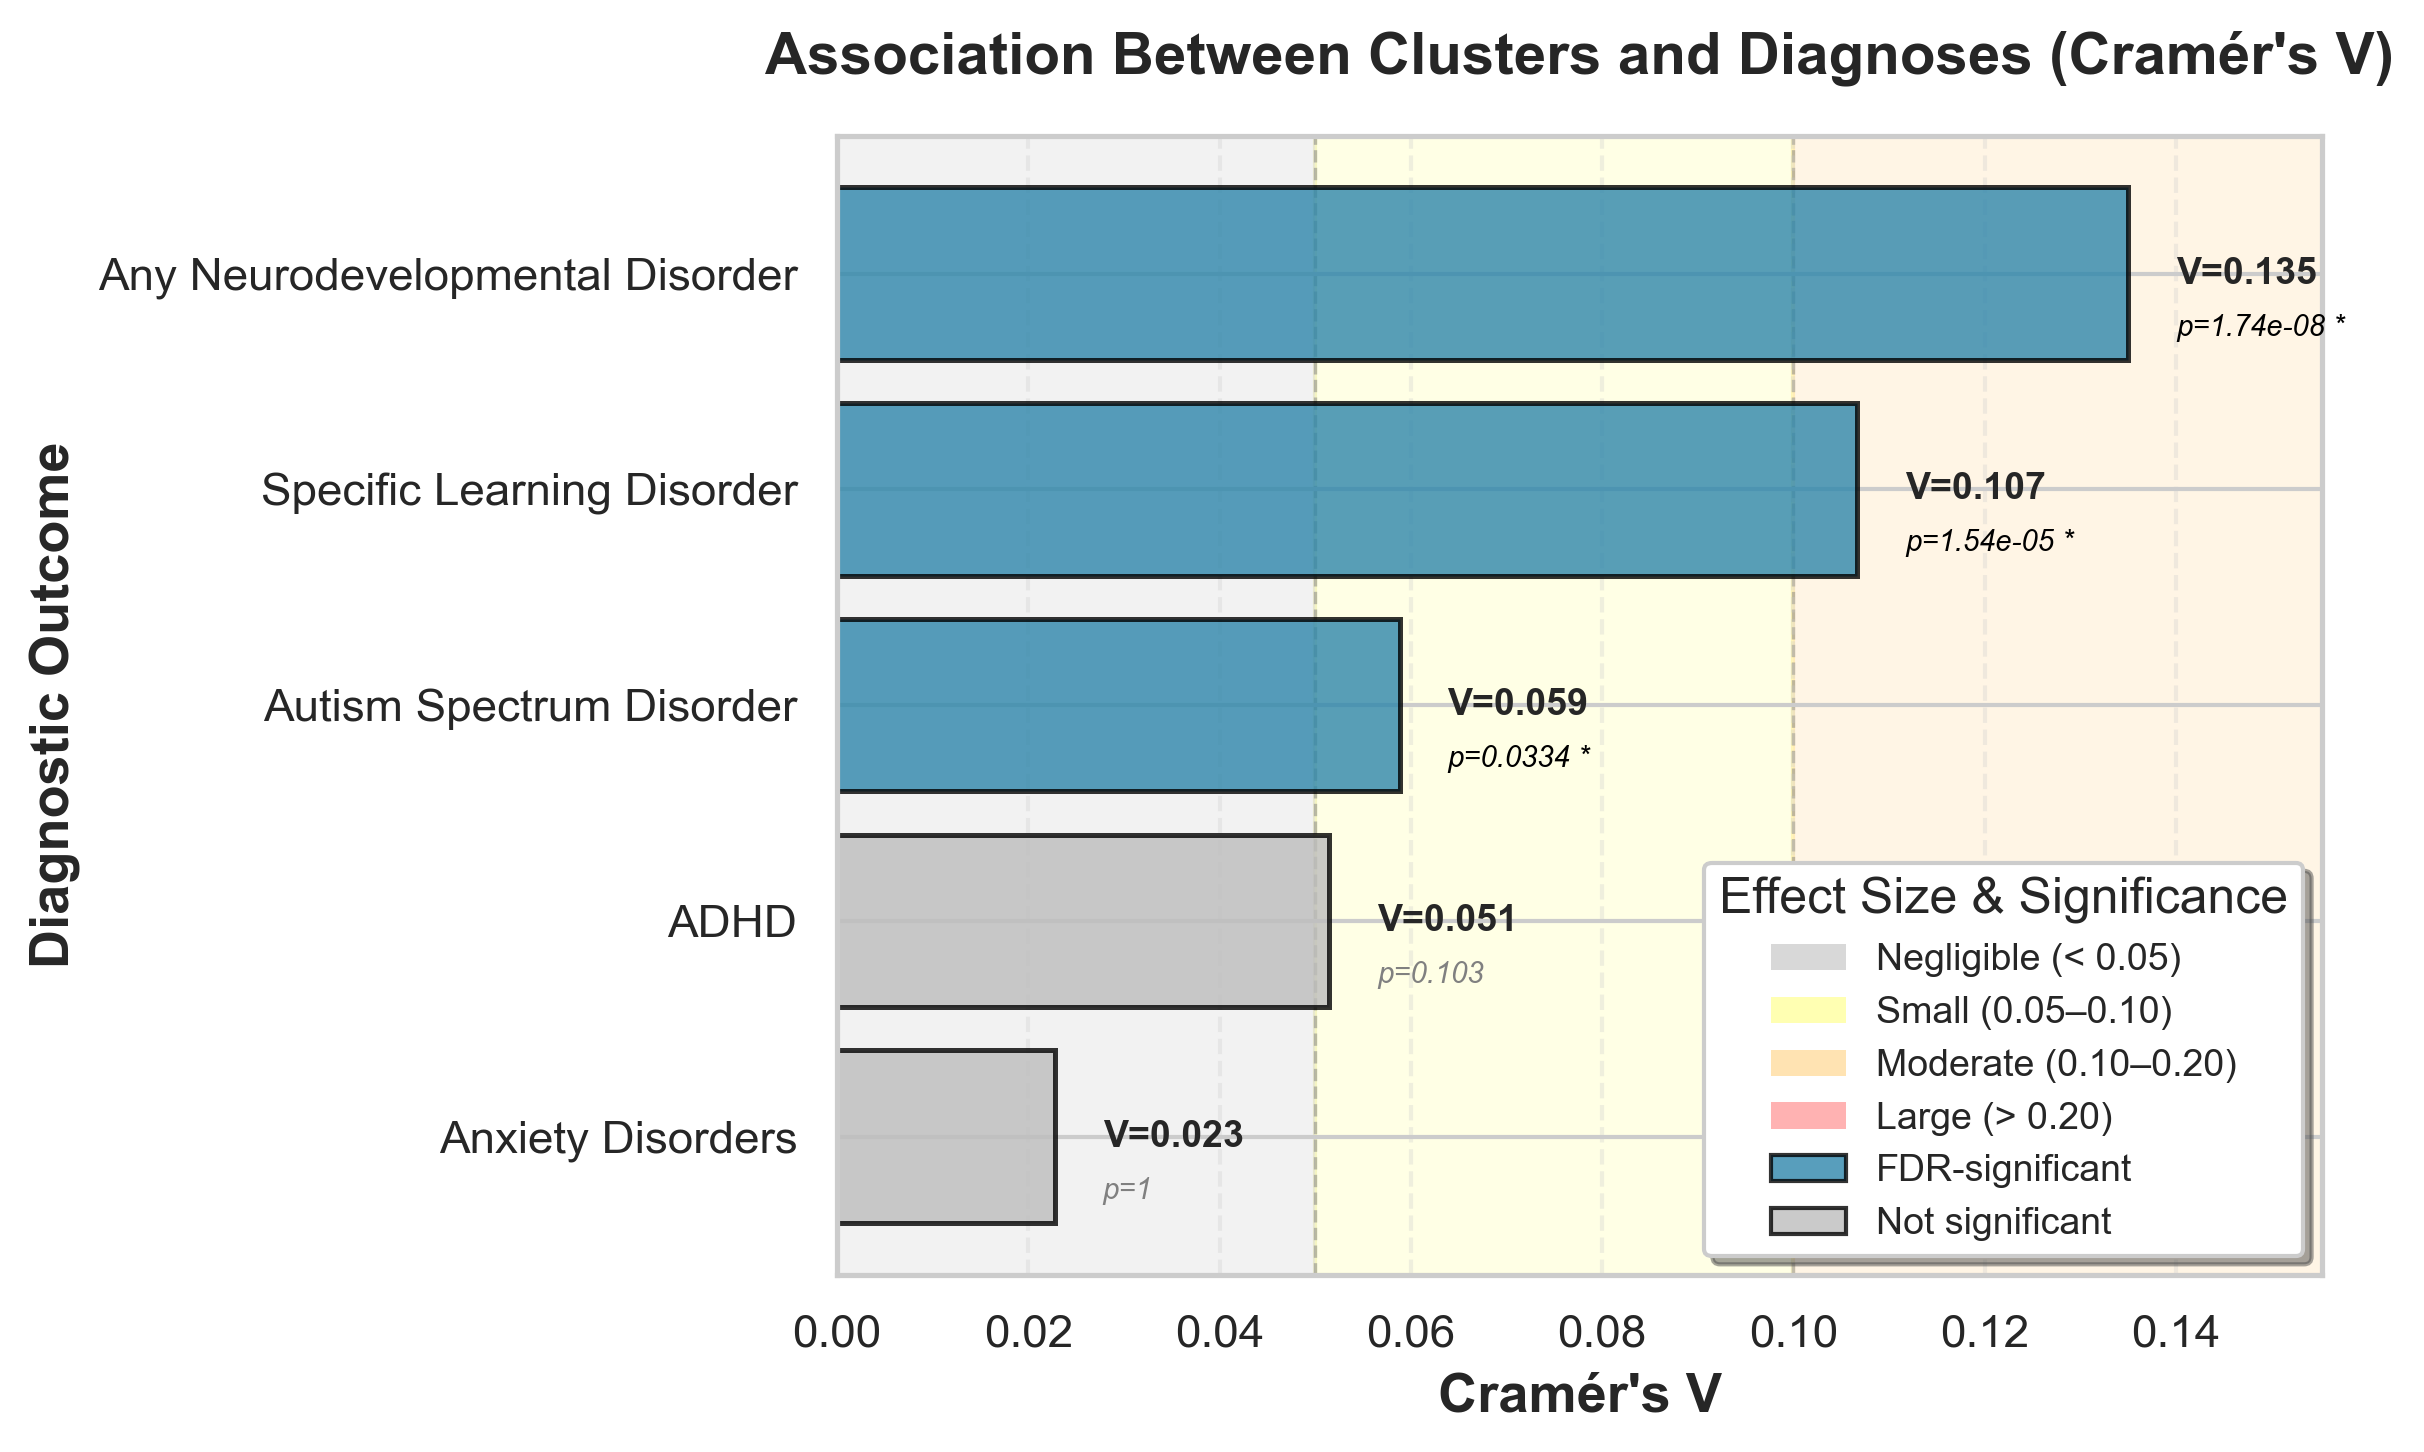

In [61]:
# Dictionary to map diagnosis labels to full disorder names
DISORDER_NAMES = {
    "Neuro_any": "Any Neurodevelopmental Disorder",
    "SLD_any": "Specific Learning Disorder",
    "ASD_any": "Autism Spectrum Disorder",
    "ADHD_any": "ADHD",
    "Anxiety_any": "Anxiety Disorders"
}

# Add readable names to dataframe
chi_df['disorder_name'] = chi_df['diagnosis_label'].map(DISORDER_NAMES)


# =============================================================================
# CRAMÉR'S V PLOT
# =============================================================================

# Sort diagnoses by effect size (Cramér's V)
plot_df = chi_df.sort_values("cramers_v", ascending=True).reset_index(drop=True)

y_pos = np.arange(len(plot_df))

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# Colors: darker for FDR-significant, lighter for non-significant
colors = ["#2E86AB" if sig else "#BDBDBD" for sig in plot_df["sig_fdr"]]

# Plot bars
bars = ax.barh(
    y_pos,
    plot_df["cramers_v"],
    color=colors,
    alpha=0.8,
    edgecolor="black",
    linewidth=1.2
)

# Shaded regions for interpretation (behind bars)
# Based on Cramér's V benchmarks for 4 clusters
ax.axvspan(0.00, 0.05, alpha=0.1, color='gray', zorder=0, label='Negligible')
ax.axvspan(0.05, 0.10, alpha=0.1, color='yellow', zorder=0, label='Small')
ax.axvspan(0.10, 0.20, alpha=0.1, color='orange', zorder=0, label='Moderate')
ax.axvspan(0.20, 0.30, alpha=0.1, color='red', zorder=0, label='Large')

# Reference lines (subtle)
for v in [0.05, 0.10, 0.20]:
    ax.axvline(v, color="gray", linestyle="--", linewidth=0.8, alpha=0.5, zorder=0)

# Y-axis labels (full disorder names)
ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df["disorder_name"])

# Value labels with p-values
for i, (v, p_fdr, sig) in plot_df[["cramers_v", "p_fdr", "sig_fdr"]].iterrows():
    # Value label
    ax.text(
        v + 0.005, i,
        f"V={v:.3f}",
        va="center", ha="left",
        fontsize=9, fontweight='bold'
    )
    # P-value annotation (smaller, below)
    p_text = f"p={p_fdr:.3g}" + (" *" if sig else "")
    ax.text(
        v + 0.005, i - 0.25,
        p_text,
        va="center", ha="left",
        fontsize=7,
        style='italic',
        color='black' if sig else 'gray'
    )

# Create legend
legend_elements = [
    # Interpretation zones
    mpatches.Patch(facecolor='gray', alpha=0.3, edgecolor='none', 
                   label='Negligible (< 0.05)'),
    mpatches.Patch(facecolor='yellow', alpha=0.3, edgecolor='none', 
                   label='Small (0.05–0.10)'),
    mpatches.Patch(facecolor='orange', alpha=0.3, edgecolor='none', 
                   label='Moderate (0.10–0.20)'),
    mpatches.Patch(facecolor='red', alpha=0.3, edgecolor='none', 
                   label='Large (> 0.20)'),
    # Significance
    mpatches.Patch(facecolor='#2E86AB', alpha=0.8, edgecolor='black', 
                   label='FDR-significant'),
    mpatches.Patch(facecolor='#BDBDBD', alpha=0.8, edgecolor='black', 
                   label='Not significant')
]

ax.legend(handles=legend_elements, loc='lower right', 
          fontsize=9, frameon=True, shadow=True, title='Effect Size & Significance')

ax.set_xlabel("Cramér's V", fontsize=13, fontweight='bold')
ax.set_ylabel("Diagnostic Outcome", fontsize=13, fontweight='bold')
ax.set_title("Association Between Clusters and Diagnoses (Cramér's V)",
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, max(plot_df["cramers_v"]) * 1.15)  # Extra space for labels
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()

out_path = RESULTS_DIR / "cramersV_by_diagnosis.png"
fig.savefig(out_path, bbox_inches="tight", dpi=300, facecolor='white')
plt.show()

# Diagnostic Utility of Clusters

## Incremental & Absolute Utility

In [25]:
EF_TD_COLS = [
    "NIH_final,NIH_Flanker_Age_Corr_Stnd",      # EF: Inhibitory control
    "NIH_final,NIH_List_Sort_Age_Corr_Stnd",    # EF: Working memory
    "NIH_final,NIH_Processing_Age_Corr_Stnd",   # EF: Processing speed
    "logk_mean",                                 # TD: Discount rate
    "k_abs_diff_log" 
]

print("EF/TD predictors:", EF_TD_COLS)

# Outcomes to test incremental utility on
OUTCOME_COLS = [
    "dx_neuro_any",  # strong chi-square + V
    "dx_sld_any",    # strong chi-square + V
    "dx_asd_any",    # smaller but sig chi-square + V
    "dx_adhd_any",
    "dx_anx_any"
]

OUTCOME_COLS

EF/TD predictors: ['NIH_final,NIH_Flanker_Age_Corr_Stnd', 'NIH_final,NIH_List_Sort_Age_Corr_Stnd', 'NIH_final,NIH_Processing_Age_Corr_Stnd', 'logk_mean', 'k_abs_diff_log']


['dx_neuro_any', 'dx_sld_any', 'dx_asd_any', 'dx_adhd_any', 'dx_anx_any']

In [26]:
def compute_cv_auc(X: pd.DataFrame,
                   y: pd.Series,
                   n_splits: int = 5,
                   random_state: int = 42):
    """
    Returns mean and SD of cross-validated AUC using
    LogisticRegression with standardization.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    aucs = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                max_iter=1000,
                class_weight="balanced",  # helps with imbalance
                solver="lbfgs"
            )),
        ])

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        aucs.append(auc)

    aucs = np.array(aucs)
    return aucs.mean(), aucs.std()

In [37]:
# COMBINED ANALYSIS: Incremental AND Absolute Utility

results_rows = []

for outcome in OUTCOME_COLS:
    # Prepare data
    needed_cols = EF_TD_COLS + ["cluster", outcome]
    sub = df_all.dropna(subset=needed_cols).copy()

    if sub.empty:
        print(f"\n⚠ No data for outcome {outcome}, skipping.")
        continue

    y = sub[outcome].astype(int)

    # Three predictor sets:
    # 1. EF/TD only (baseline)
    X_base = sub[EF_TD_COLS]

    # 2. Clusters only
    cluster_dummies = pd.get_dummies(
        sub["cluster"].astype("category"),
        prefix="cluster",
        drop_first=True
    )
    X_cluster = cluster_dummies

    # 3. EF/TD + Clusters (combined)
    X_plus = pd.concat([X_base, cluster_dummies], axis=1)

    # Compute CV-AUCs for all three
    base_mean, base_sd = compute_cv_auc(X_base, y)
    cluster_mean, cluster_sd = compute_cv_auc(X_cluster, y)
    plus_mean, plus_sd = compute_cv_auc(X_plus, y)

    # Summary output
    print(f"\n{'='*70}")
    print(f"Outcome: {outcome}")
    print(f"  N = {len(sub):,} | Positive cases = {int(y.sum()):,} ({100*y.mean():.1f}%)")
    print(f"\n  Model Performance (AUC ± SD):")
    print(f"    EF/TD only      : {base_mean:.3f} ± {base_sd:.3f}")
    print(f"    Clusters only   : {cluster_mean:.3f} ± {cluster_sd:.3f}")
    print(f"    EF/TD + Clusters: {plus_mean:.3f} ± {plus_sd:.3f}")
    print(f"\n  Comparisons:")
    print(f"    ΔAUC (Clusters vs EF/TD)     : {cluster_mean - base_mean:+.3f}")
    print(f"    ΔAUC (Combined vs EF/TD)     : {plus_mean - base_mean:+.3f}")
    print(f"    ΔAUC (Combined vs Clusters)  : {plus_mean - cluster_mean:+.3f}")

    results_rows.append({
        "outcome": outcome,
        "n": len(sub),
        "n_positive": int(y.sum()),
        "prevalence": y.mean(),
        # Model performance
        "auc_base_mean": base_mean,
        "auc_base_sd": base_sd,
        "auc_cluster_mean": cluster_mean,
        "auc_cluster_sd": cluster_sd,
        "auc_plus_mean": plus_mean,
        "auc_plus_sd": plus_sd,
        # Deltas
        "delta_cluster_vs_base": cluster_mean - base_mean,
        "delta_plus_vs_base": plus_mean - base_mean,
        "delta_plus_vs_cluster": plus_mean - cluster_mean,
    })

# Create results dataframe
auc_results = pd.DataFrame(results_rows)
display(auc_results.round(3))

# Save results
#out_path = RESULTS_DIR / "diagnostic_utility_complete.csv"
#auc_results.to_csv(out_path, index=False)


Outcome: dx_neuro_any
  N = 1,908 | Positive cases = 1,551 (81.3%)

  Model Performance (AUC ± SD):
    EF/TD only      : 0.619 ± 0.040
    Clusters only   : 0.580 ± 0.047
    EF/TD + Clusters: 0.608 ± 0.043

  Comparisons:
    ΔAUC (Clusters vs EF/TD)     : -0.039
    ΔAUC (Combined vs EF/TD)     : -0.011
    ΔAUC (Combined vs Clusters)  : +0.028

Outcome: dx_sld_any
  N = 1,908 | Positive cases = 509 (26.7%)

  Model Performance (AUC ± SD):
    EF/TD only      : 0.598 ± 0.028
    Clusters only   : 0.547 ± 0.025
    EF/TD + Clusters: 0.590 ± 0.024

  Comparisons:
    ΔAUC (Clusters vs EF/TD)     : -0.051
    ΔAUC (Combined vs EF/TD)     : -0.008
    ΔAUC (Combined vs Clusters)  : +0.043

Outcome: dx_asd_any
  N = 1,908 | Positive cases = 308 (16.1%)

  Model Performance (AUC ± SD):
    EF/TD only      : 0.572 ± 0.012
    Clusters only   : 0.547 ± 0.021
    EF/TD + Clusters: 0.563 ± 0.011

  Comparisons:
    ΔAUC (Clusters vs EF/TD)     : -0.025
    ΔAUC (Combined vs EF/TD)     : -0.0

,outcome,n,n_positive,prevalence,auc_base_mean,auc_base_sd,auc_cluster_mean,auc_cluster_sd,auc_plus_mean,auc_plus_sd,delta_cluster_vs_base,delta_plus_vs_base,delta_plus_vs_cluster
0,dx_neuro_any,1908,1551,0.813,0.619,0.040,0.580,0.047,0.608,0.043,-0.039,-0.011,0.028
1,dx_sld_any,1908,509,0.267,0.598,0.028,0.547,0.025,0.590,0.024,-0.051,-0.008,0.043
2,dx_asd_any,1908,308,0.161,0.572,0.012,0.547,0.021,0.563,0.011,-0.025,-0.009,0.016
3,dx_adhd_any,1908,1249,0.655,0.551,0.021,0.523,0.009,0.545,0.025,-0.028,-0.006,0.022
4,dx_anx_any,1908,724,0.379,0.546,0.026,0.510,0.030,0.551,0.030,-0.036,0.005,0.041


> Cluster membership alone captured a similar amount of diagnostic information as the continuous EF/TD scores, consistent with clusters being a compact, interpretable representation of the same underlying dimensions.

## Visualization

### Comprehensive Comparison of Predictive Utility

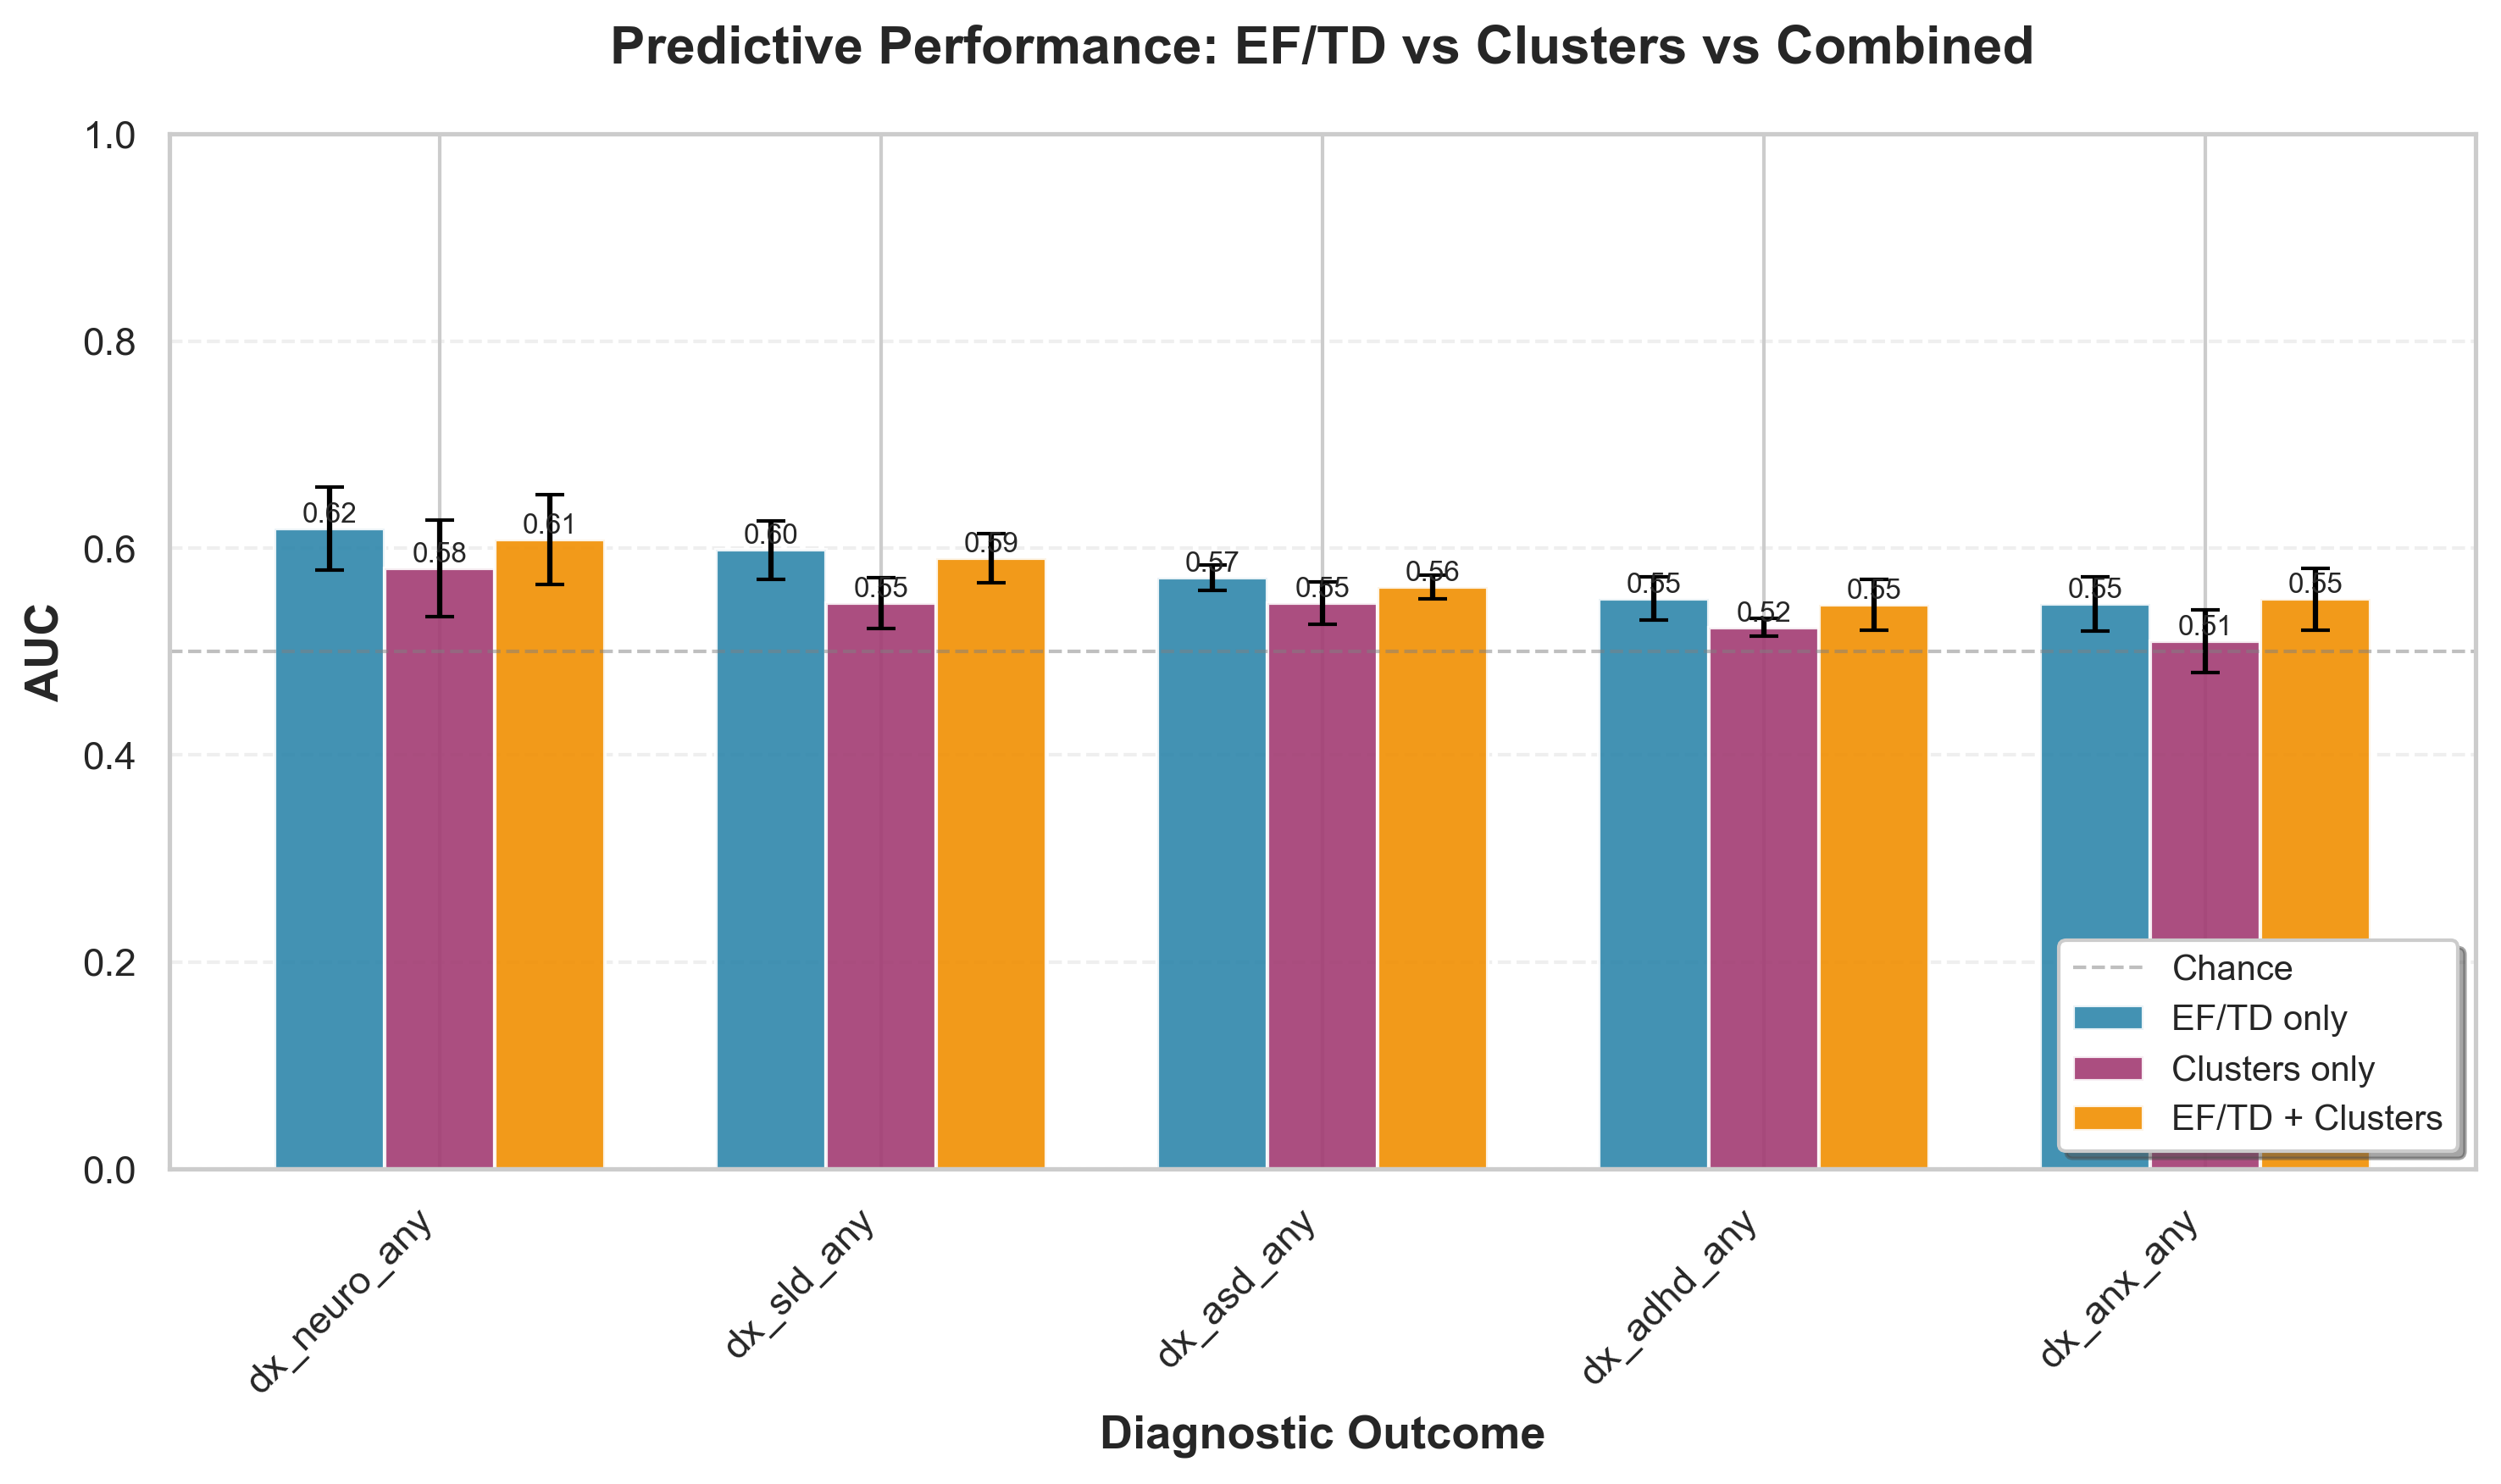

In [55]:
# Prepare data for plotting
plot_df = auc_results.sort_values("auc_base_mean", ascending=False).copy()

# Create figure
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

x = np.arange(len(plot_df))
width = 0.25

# Three groups of bars
bars1 = ax.bar(x - width, plot_df["auc_base_mean"], width, 
               label="EF/TD only", color="#2E86AB", alpha=0.9,
               yerr=plot_df["auc_base_sd"], capsize=4, error_kw={"linewidth": 1.5})

bars2 = ax.bar(x, plot_df["auc_cluster_mean"], width,
               label="Clusters only", color="#A23B72", alpha=0.9,
               yerr=plot_df["auc_cluster_sd"], capsize=4, error_kw={"linewidth": 1.5})

bars3 = ax.bar(x + width, plot_df["auc_plus_mean"], width,
               label="EF/TD + Clusters", color="#F18F01", alpha=0.9,
               yerr=plot_df["auc_plus_sd"], capsize=4, error_kw={"linewidth": 1.5})

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

# Formatting
ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
ax.set_xlabel('Diagnostic Outcome', fontsize=13, fontweight='bold')
ax.set_title('Predictive Performance: EF/TD vs Clusters vs Combined',
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(plot_df["outcome"], rotation=45, ha='right')
ax.set_ylim(0.0, 1.0)
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Chance')
ax.legend(loc='lower right', fontsize=10, frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
out_path = RESULTS_DIR / "diagnostic_utility_comprehensive.png"
fig.savefig(out_path, bbox_inches="tight", dpi=300, facecolor='white')
plt.show()

### ABSOLUTE UTILITY (Clusters vs EF/TD)
Shows whether clusters capture same info as raw scores

In [59]:
# Dictionary to map variable names to full disorder names
DISORDER_NAMES = {
    "dx_neuro_any": "Any Neurodevelopmental Disorder",
    "dx_sld_any": "Specific Learning Disorder",
    "dx_asd_any": "Autism Spectrum Disorder",
    "dx_adhd_any": "ADHD",
    "dx_anx_any": "Anxiety Disorders"
}

# Add readable names to dataframe
plot_df['disorder_name'] = plot_df['outcome'].map(DISORDER_NAMES)


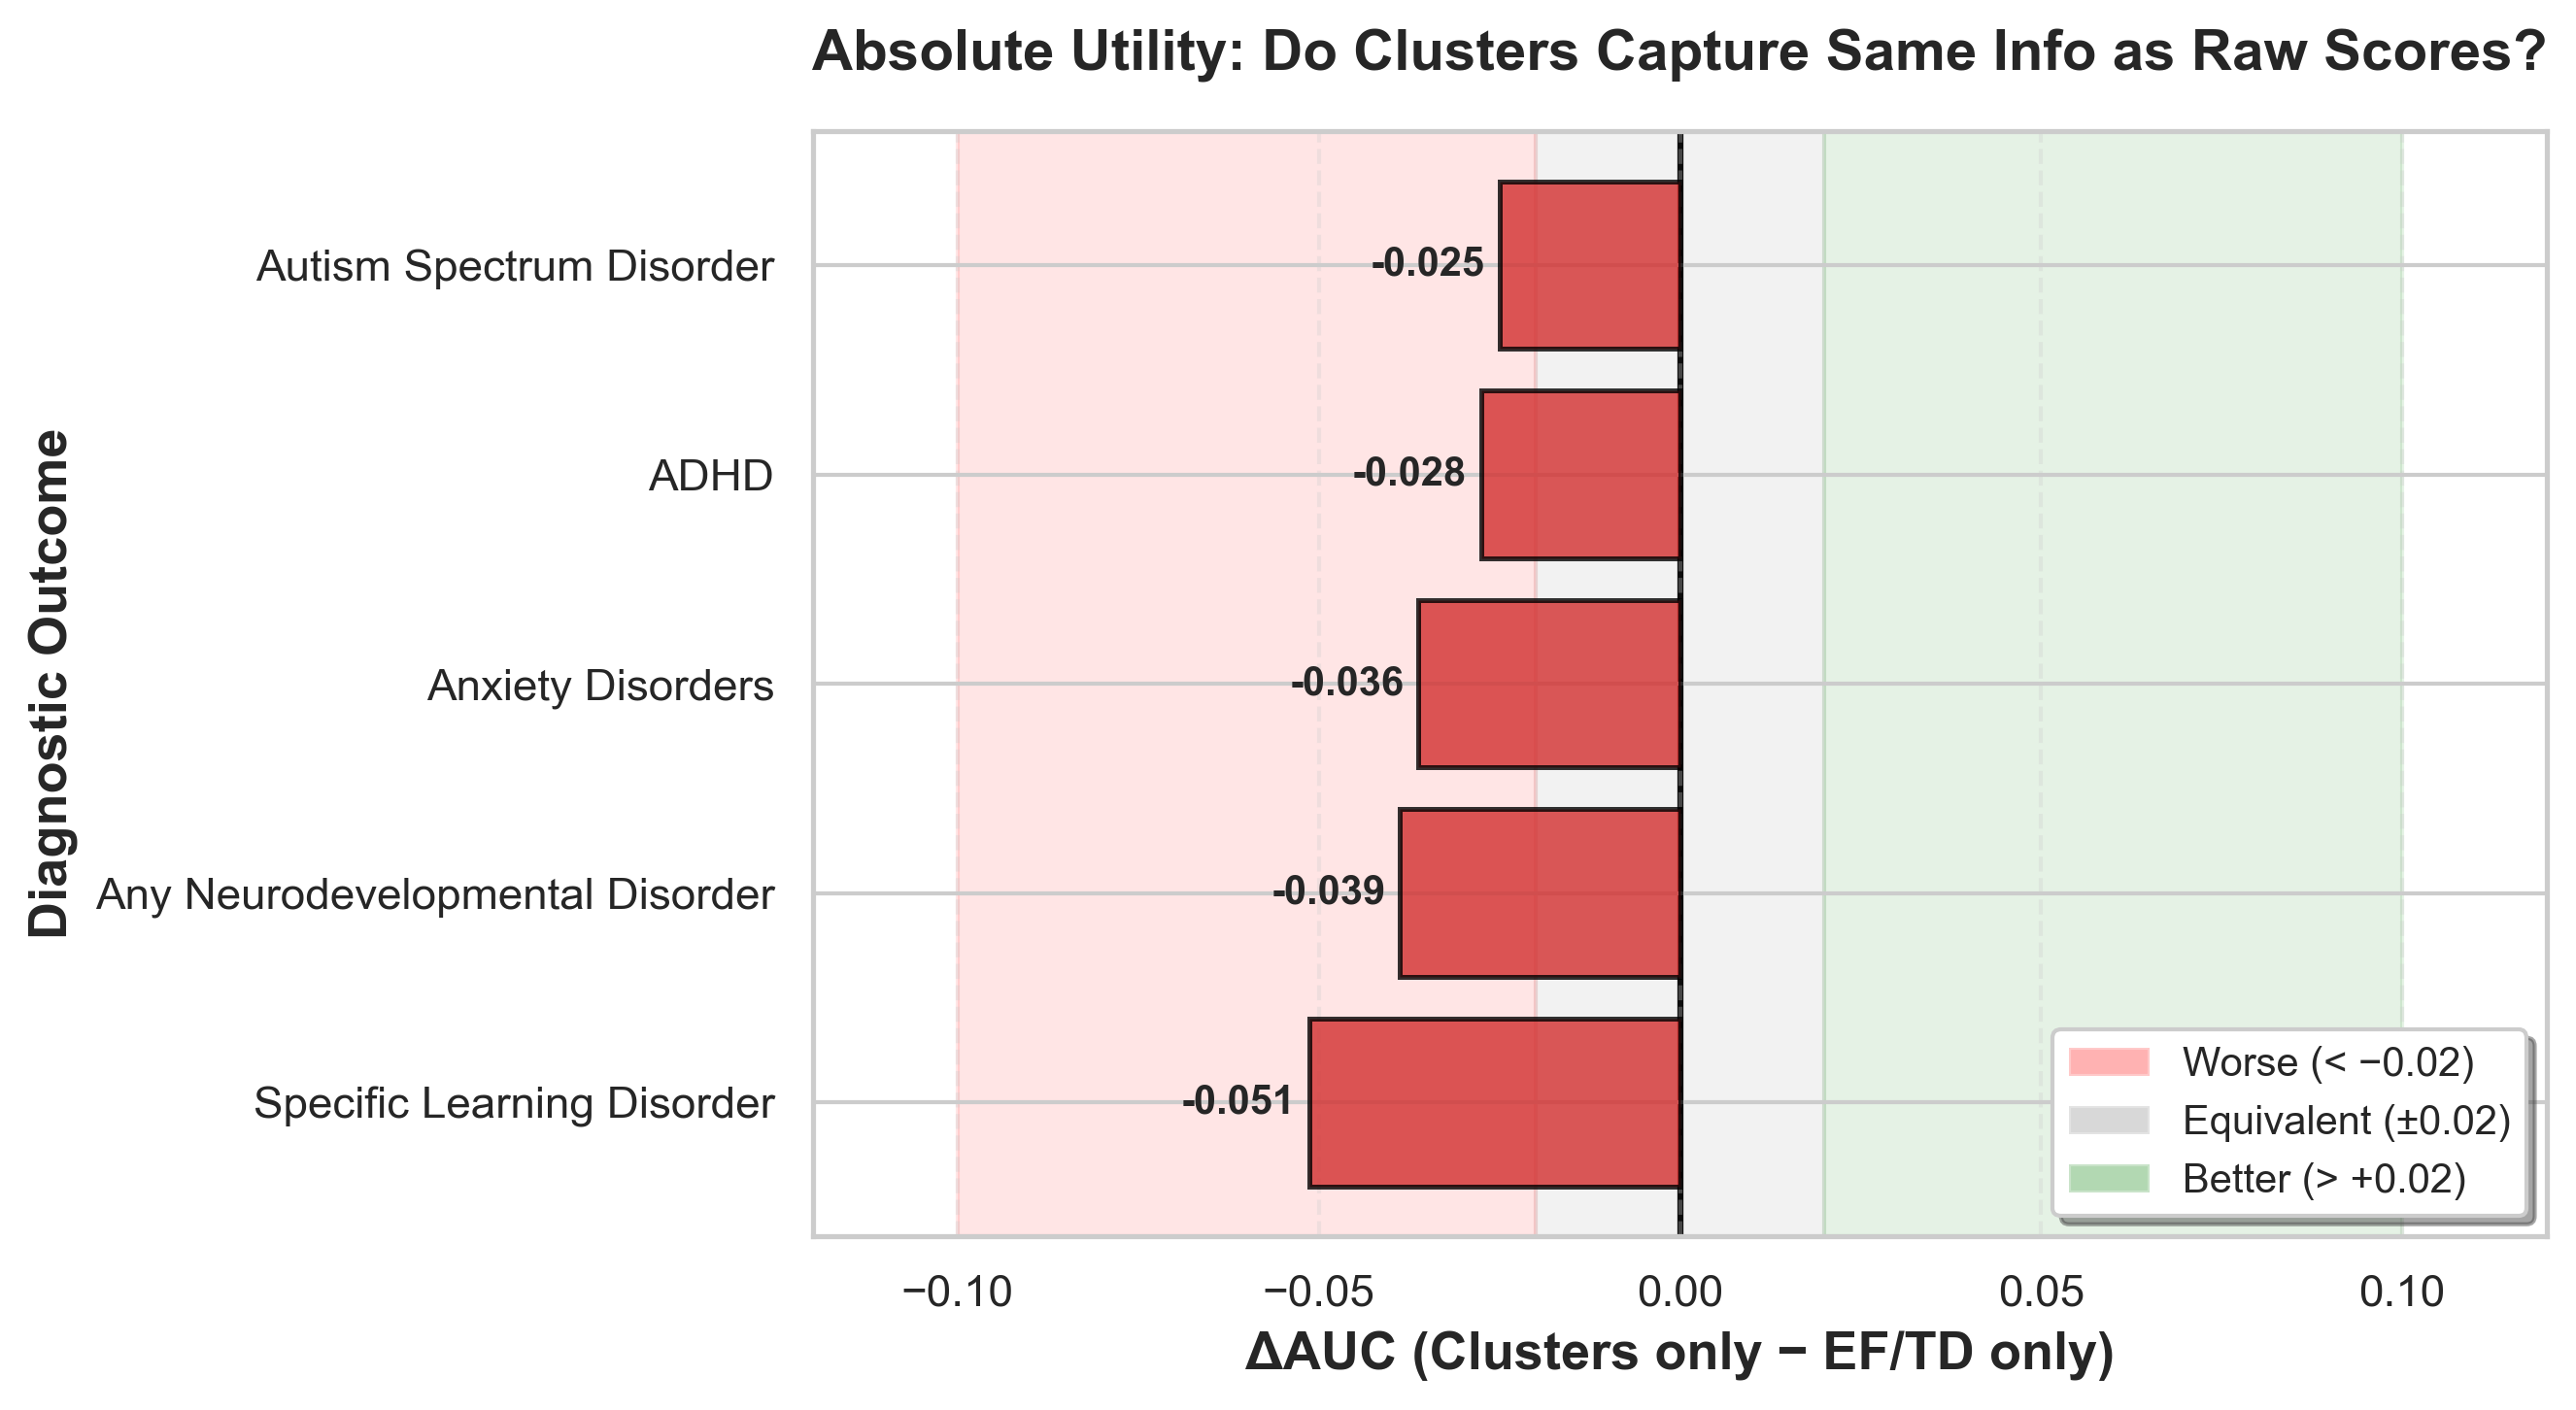

In [58]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=300)

sorted_df = plot_df.sort_values("delta_cluster_vs_base", ascending=True)
colors = ['#D32F2F' if d < 0 else '#388E3C' for d in sorted_df["delta_cluster_vs_base"]]

bars = ax.barh(sorted_df["disorder_name"], sorted_df["delta_cluster_vs_base"],
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

ax.axvline(0, color='black', linestyle='-', linewidth=1.5, zorder=0)
ax.axvspan(-0.10, -0.02, alpha=0.1, color='red', zorder=0)
ax.axvspan(-0.02, 0.02, alpha=0.1, color='gray', zorder=0)
ax.axvspan(0.02, 0.10, alpha=0.1, color='green', zorder=0)

for i, (disorder, delta) in enumerate(zip(sorted_df["disorder_name"], 
                                           sorted_df["delta_cluster_vs_base"])):
    ax.text(delta + (0.002 if delta >= 0 else -0.002), i, f'{delta:+.3f}',
            va='center', ha='left' if delta >= 0 else 'right',
            fontsize=10, fontweight='bold')

# Simplified legend - just interpretation zones
legend_elements = [
    mpatches.Patch(facecolor='red', alpha=0.3, label='Worse (< −0.02)'),
    mpatches.Patch(facecolor='gray', alpha=0.3, label='Equivalent (±0.02)'),
    mpatches.Patch(facecolor='green', alpha=0.3, label='Better (> +0.02)')
]

ax.legend(handles=legend_elements, loc='lower right', 
          fontsize=10, frameon=True, shadow=True)

ax.set_xlabel('ΔAUC (Clusters only − EF/TD only)', fontsize=13, fontweight='bold')
ax.set_ylabel('Diagnostic Outcome', fontsize=13, fontweight='bold')
ax.set_title('Absolute Utility: Do Clusters Capture Same Info as Raw Scores?',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(-0.12, 0.12)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
out_path = RESULTS_DIR / "diagnostic_utility_clusters_vs_raw_simple.png"
fig.savefig(out_path, bbox_inches="tight", dpi=300, facecolor='white')
plt.show()

### INCREMENTAL UTILITY (Adding Clusters to EF/TD)
Shows whether adding clusters improves prediction

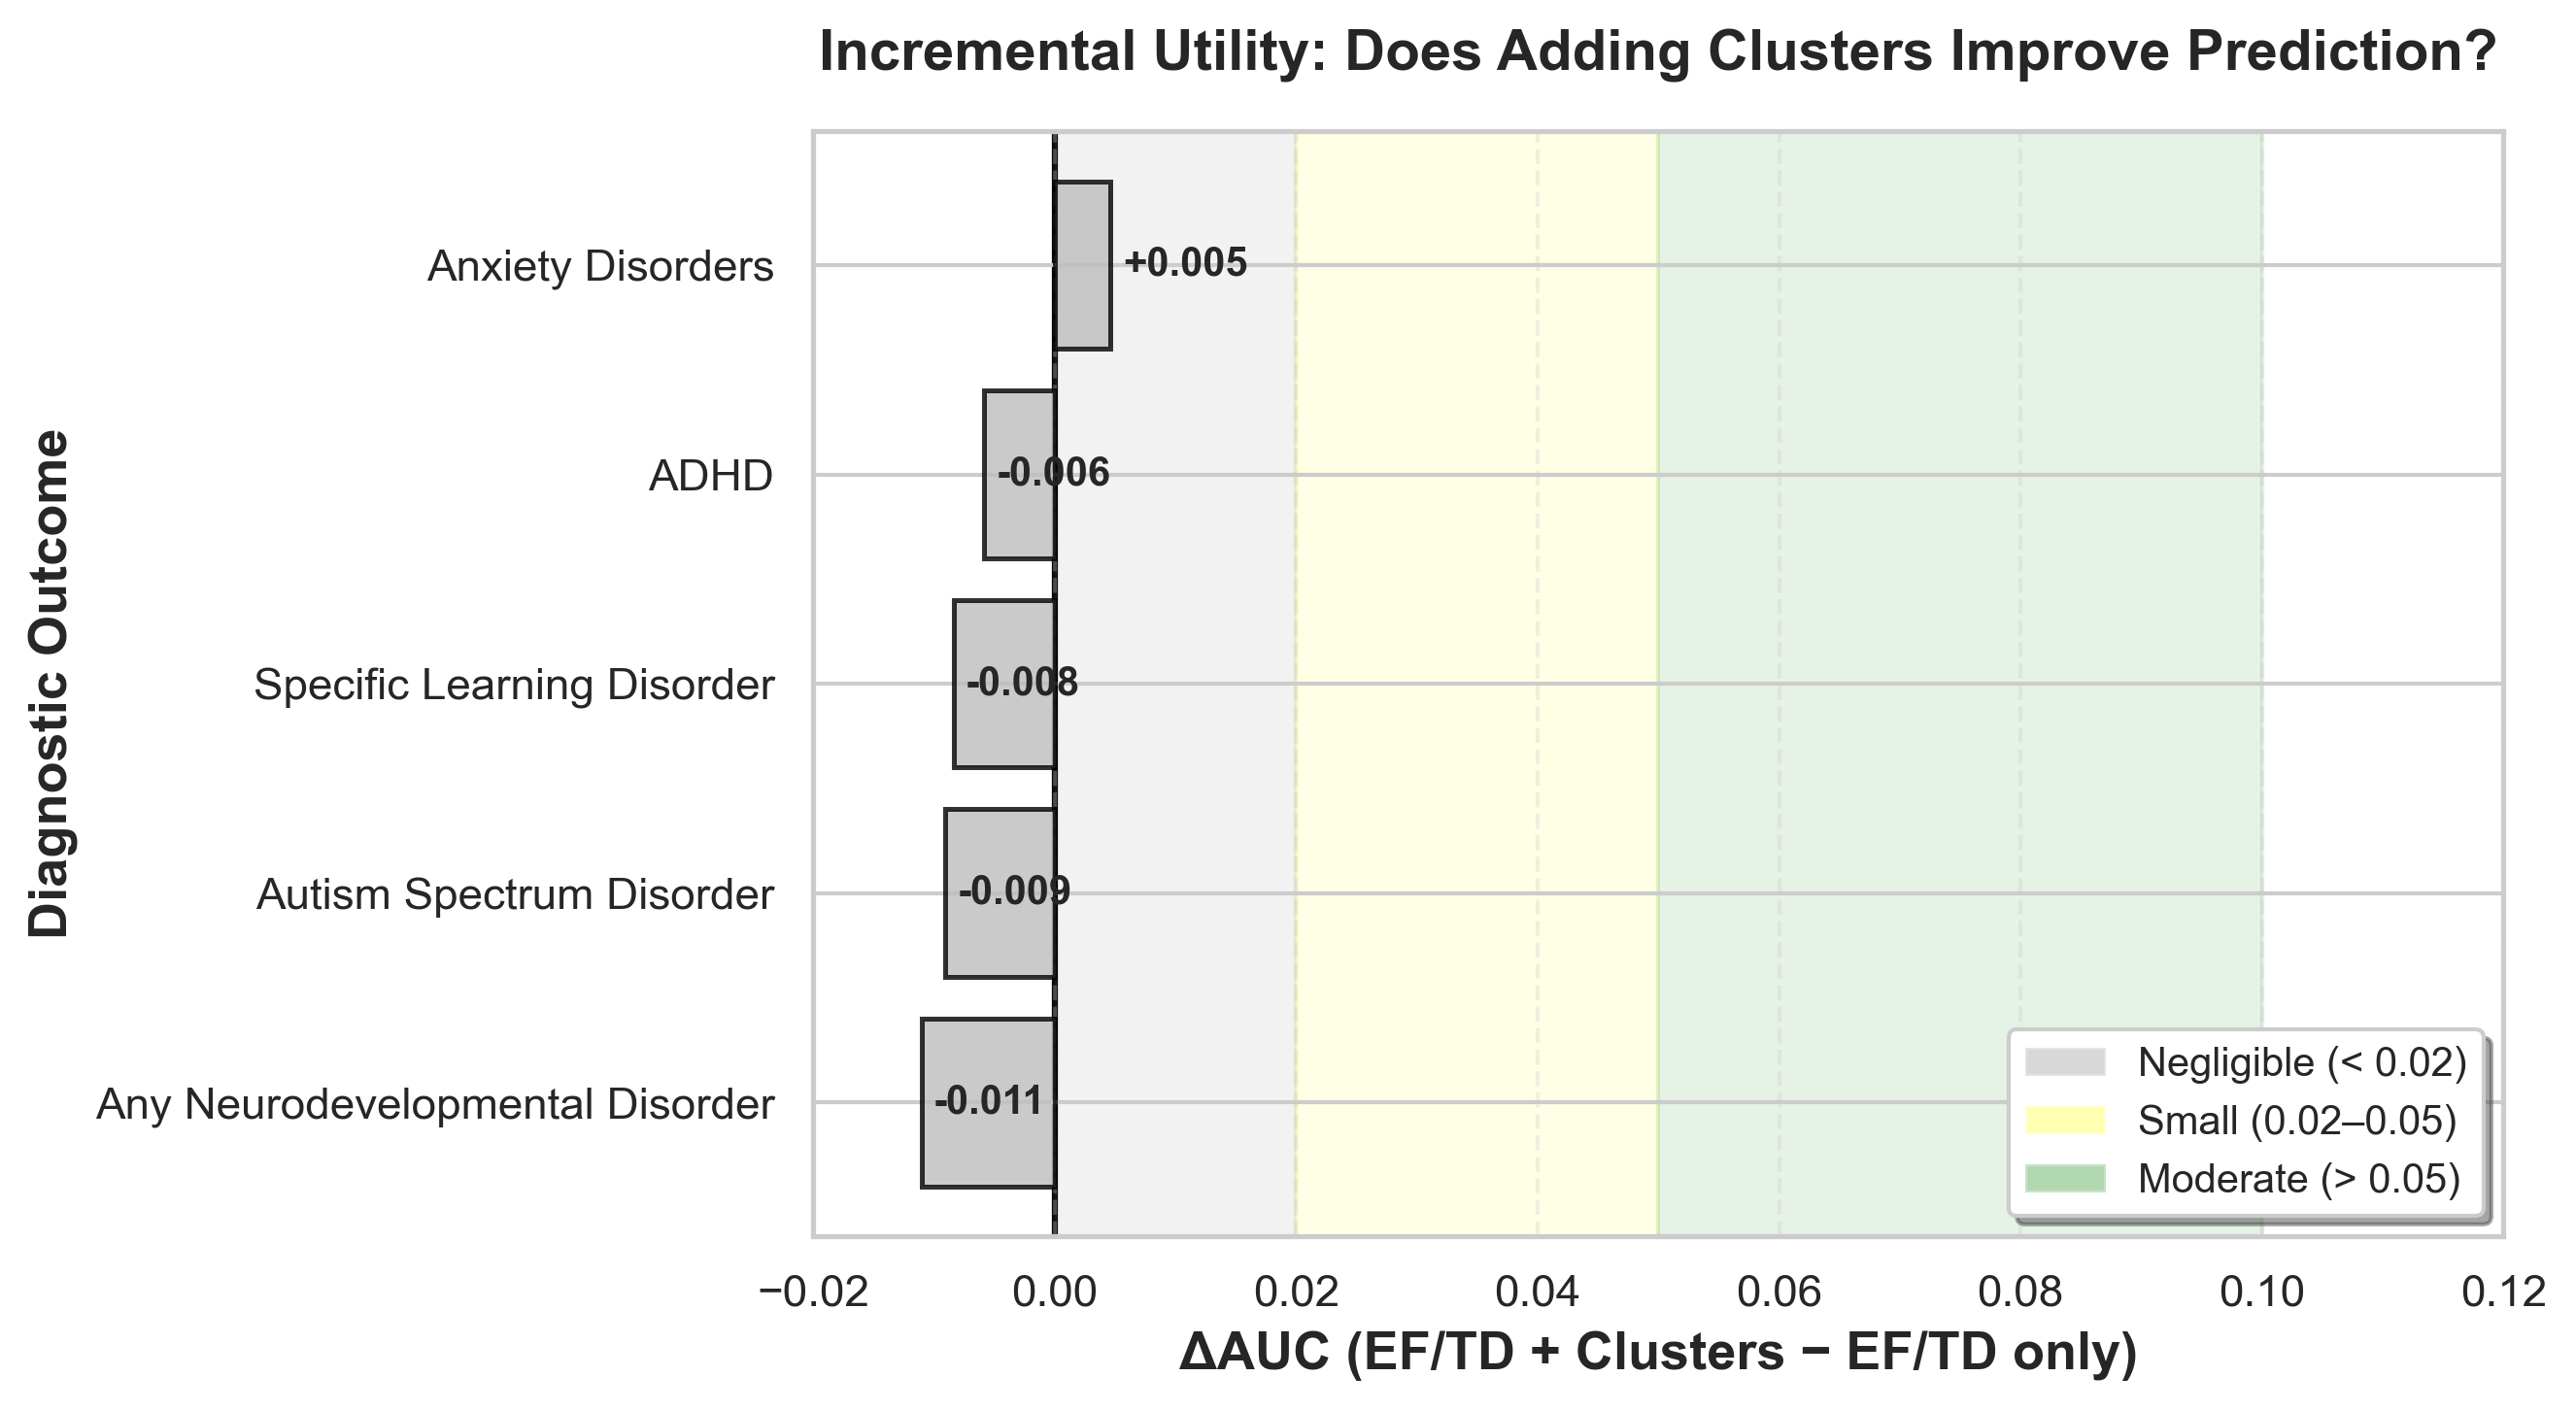

In [48]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=300)

sorted_df = plot_df.sort_values("delta_plus_vs_base", ascending=True)
colors = ['#1f77b4' if d >= 0.01 else '#bdbdbd' for d in sorted_df["delta_plus_vs_base"]]

bars = ax.barh(sorted_df["disorder_name"], sorted_df["delta_plus_vs_base"],
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

ax.axvline(0, color='black', linestyle='-', linewidth=1.5, zorder=0)
ax.axvspan(0.00, 0.02, alpha=0.1, color='gray', zorder=0)
ax.axvspan(0.02, 0.05, alpha=0.1, color='yellow', zorder=0)
ax.axvspan(0.05, 0.10, alpha=0.1, color='green', zorder=0)

for i, (disorder, delta) in enumerate(zip(sorted_df["disorder_name"],
                                           sorted_df["delta_plus_vs_base"])):
    ax.text(delta + 0.001, i, f'{delta:+.3f}',
            va='center', ha='left', fontsize=10, fontweight='bold')

# Simplified legend - just interpretation zones
legend_elements = [
    mpatches.Patch(facecolor='gray', alpha=0.3, label='Negligible (< 0.02)'),
    mpatches.Patch(facecolor='yellow', alpha=0.3, label='Small (0.02–0.05)'),
    mpatches.Patch(facecolor='green', alpha=0.3, label='Moderate (> 0.05)')
]

ax.legend(handles=legend_elements, loc='lower right', 
          fontsize=10, frameon=True, shadow=True)

ax.set_xlabel('ΔAUC (EF/TD + Clusters − EF/TD only)', fontsize=13, fontweight='bold')
ax.set_ylabel('Diagnostic Outcome', fontsize=13, fontweight='bold')
ax.set_title('Incremental Utility: Does Adding Clusters Improve Prediction?',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(-0.02, 0.12)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
out_path = RESULTS_DIR / "diagnostic_utility_incremental_simple.png"
fig.savefig(out_path, bbox_inches="tight", dpi=300, facecolor='white')
plt.show()